###### ScanNet

This notebook lets you instantiate the **[ScanNet](http://www.scan-net.org/)** dataset from scratch and visualize **3D+2D room samples**.

Note that you will need **at least 1.2T** available for the SanNet raw dataset and **at least 64G** for the processed files at **5cm voxel resolution** and **320x240 image resolution**. 

The ScanNet dataset is composed of **rooms** of video acquisitions of indoor scenes. Thes video streams were used to produce a point cloud and images.

Each room is small enough to be loaded at once into a **64G RAM** memory. The `ScannetDatasetMM` class from `torch_points3d.datasets.segmentation.multimodal.scannet` deals with loading the room and part of the images of the associated video stream.

In [1]:
# Select you GPU
I_GPU = 0


In [2]:
# Uncomment to use autoreload
%load_ext autoreload
%autoreload 2

import os
import os.path as osp
import sys
import torch
import numpy as np
from time import time
from omegaconf import OmegaConf
start = time()
import warnings
warnings.filterwarnings('ignore')

# torch.cuda.set_device(I_GPU)
DIR = os.path.dirname(os.getcwd())
ROOT = os.path.join(DIR, "..")
sys.path.insert(0, ROOT)
sys.path.insert(0, DIR)

from torch_points3d.utils.config import hydra_read
from torch_geometric.data import Data
from torch_points3d.core.multimodal.data import MMData, MMBatch
from torch_points3d.visualization.multimodal_data import visualize_mm_data
from torch_points3d.core.multimodal.image import SameSettingImageData, ImageData
from torch_points3d.datasets.segmentation.multimodal.scannet import ScannetDatasetMM
from torch_points3d.datasets.segmentation.scannet import CLASS_COLORS, CLASS_NAMES, CLASS_LABELS
from torch_points3d.metrics.segmentation_tracker import SegmentationTracker

from pykeops.torch import LazyTensor

import matplotlib.pyplot as plt 

%matplotlib inline

MMData debug() function changed, please uncomment the 3rd assert line when doing inference without M2F features!


In [3]:
CLASS_COLORS[0] = (174.0, 199.0, 232.0)
CLASS_COLORS[-1] = (0, 0, 0)

If `visualize_mm_data` does not throw any error but the visualization does not appear, you may need to change your plotly renderer below.

In [4]:
import plotly.io as pio

#pio.renderers.default = 'jupyterlab'        # for local notebook
pio.renderers.default = 'iframe_connected'  # for remote notebook. Other working (but seemingly slower) options are: 'sphinx_gallery' and 'iframe'

In [5]:
# Set your dataset root directory, where the data was/will be downloaded
DATA_ROOT = '/scratch-shared/fsun/dvata'

dataset_config = 'segmentation/multimodal/Feng/scannet-neucon-smallres-m2f'   
models_config = 'segmentation/multimodal/Feng/mvfusion'    # model family
model_name = 'MVFusion_3D_small_6views_2d_supervision'                       # specific model

overrides = [
    'task=segmentation',
    f'data={dataset_config}',
    f'models={models_config}',
    f'model_name={model_name}',
    f'data.dataroot={DATA_ROOT}',
]

cfg = hydra_read(overrides)
OmegaConf.set_struct(cfg, False)  # This allows getattr and hasattr methods to function correctly
cfg.data.load_m2f_masks = True   # load Mask2Former predicted masks

In [6]:
cfg.data.m2f_preds_dirname = 'ViT_masks'
cfg.data.n_views = cfg.models[model_name].backbone.transformer.n_views
print(cfg.data.n_views)

6


The dataset will now be created based on the parsed configuration. I recommend having **at least 1.2T** available for the SanNet raw dataset and **at least 64G** for the processed files at **5cm voxel resolution** and **320x240 image resolution**. 

As long as you do not change core dataset parameters, preprocessing should only be performed once for your dataset. It may take some time, **mostly depending on the 3D and 2D resolutions** you choose to work with (the larger the slower).

In [7]:
# Dataset instantiation
start = time()
dataset = ScannetDatasetMM(cfg.data)
# print(dataset)|
print(f"Time = {time() - start:0.1f} sec.")

Load predicted 2D semantic segmentation labels from directory  ViT_masks
initialize train dataset
initialize val dataset
Time = 8.3 sec.


In [8]:
mm_data = dataset.train_dataset[0]

To visualize the multimodal samples produced by the dataset, we need to remove some of the dataset transforms that affect points, images and mappings. The `sample_real_data` function will be used to get samples without breaking mappings consistency for visualization.

At training and evaluation time, these transforms are used for data augmentation, dynamic size batching (see our [paper](https://arxiv.org/submit/4264152)), etc...

In [9]:
from torch_points3d.models.model_factory import instantiate_model

# ViT_masks 3rd run
checkpoint_dir = '/home/fsun/DeepViewAgg/outputs/ViT_masks_3rd_run' # 3rd run

# Create the model
print(f"Creating model: {cfg.model_name}")
model = instantiate_model(cfg, dataset)
# print(model)

# Load the checkpoint and recover the 'best_miou' model weights
checkpoint = torch.load(f'{checkpoint_dir}/{model_name}.pt', map_location='cpu')
model.load_state_dict_with_same_shape(checkpoint['models']['latest'], strict=False)

# Prepare the model for training
model = model.cuda()
print('Model loaded')

Creating model: MVFusion_3D_small_6views_2d_supervision
task:  segmentation.multimodal
tested_model_name:  MVFusion_3D_small_6views_2d_supervision
class_name:  MVFusionAPIModel
model_module:  torch_points3d.models.segmentation.multimodal.Feng.mvfusion_3d
name, cls of chosen model_cls:  MVFusionAPIModel <class 'torch_points3d.models.segmentation.multimodal.Feng.mvfusion_3d.MVFusionAPIModel'>
x feature dim:  {'FEAT': 3}
nc_in:  67
nc_in:  64
nc_in:  32
nc_in:  64
nc_in:  128
nc_in:  256
nc_in:  128
nc_in:  128
nc_in:  96
nc_in:  96
Model loaded


In [11]:
# print(mm_data.modalities['image'][0].get_mapped_m2f_features().shape)

# mappings = mm_data.modalities['image'][0].mappings
# point_ids = torch.arange(
#                 mappings.num_groups, device=mappings.device).repeat_interleave(
#                 mappings.pointers[1:] - mappings.pointers[:-1])

# # print(point_ids, len(point_ids))

# ### Select seen points
# csr_idx = mm_data.modalities['image'][0].view_csr_indexing
# dense_idx_list = torch.arange(mm_data.modalities['image'][0].num_points).repeat_interleave(csr_idx[1:] - csr_idx[:-1])
# # # take subset of only seen points without re-indexing the same point
# # mm_data = mm_data[dense_idx_list.unique()]

# print(csr_idx[:30], len(csr_idx))
# print(dense_idx_list[:30], len(dense_idx_list))

# print(dense_idx_list.tolist() == sorted(dense_idx_list.tolist()))


In [12]:
# n_seen = csr_idx[1:] - csr_idx[:-1]
# print(n_seen.shape)

# labels_2d = mm_data.modalities['image'][0].get_mapped_m2f_features().flatten()
# pred_2d = mm_data.data.pred.repeat_interleave(n_seen)
# print(labels_2d.shape)
# print(pred_2d.shape)

In [13]:
# # n_seen_unsqueezed = n_seen.unsqueeze(1)
# print(n_seen.shape)
# print(model.output.shape)
# pred_2d = model.output.cpu().repeat_interleave(n_seen, dim=0)
# pred_2d.shape

In [16]:
mm_data, mm_data_2 = dataset.train_dataset[0], dataset.train_dataset[1]
mm_data_2

MMData(
    data = Data(coords=[75353, 3], grid_size=[1], id_scan=[1], mapping_index=[75353], mvfusion_input=[61115, 6, 10], origin_id=[75353], pos=[75353, 3], x=[75353, 3], y=[75353])
    image = ImageData(num_settings=1, num_views=100, num_points=75353, device=cpu)
)

In [17]:
# Create a MMBatch and run inference
batch = MMBatch.from_mm_data_list([mm_data, mm_data_2])

print("input batch: ", batch)
model.set_input(batch, model.device)
model(batch)
    
# Recover the predicted labels for visualization
mm_data.data.pred = model.output.detach().cpu().argmax(1)
print(model.output.shape)

input batch:  MMBatch(
    data = Batch(batch=[146251], coords=[146251, 3], grid_size=[2], id_scan=[2], mapping_index=[146251], mvfusion_input=[119114, 6, 10], origin_id=[146251], pos=[146251, 3], ptr=[3], x=[146251, 3], y=[146251])
    image = ImageBatch(num_settings=1, num_views=200, num_points=146251, device=cpu)
)
torch.Size([146251, 20])


In [18]:
print(model.loss_seg)
print(model.loss_cross_entropy)
print(model.loss_2d_cross_entropy)

tensor(0.4532, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4816, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.4247, device='cuda:0', grad_fn=<NllLossBackward0>)


In [57]:
### Select seen points
csr_idx = mm_data.modalities['image'][0].view_csr_indexing
dense_idx_list = torch.arange(mm_data.modalities['image'][0].num_points).repeat_interleave(csr_idx[1:] - csr_idx[:-1])
# take subset of only seen points without re-indexing the same point
mm_data = mm_data[dense_idx_list.unique()]


In [58]:
# Randomly sample views
mm_data.modalities['image'] = ImageData(mm_data.modalities['image'][0][:25])

In [59]:
print(mm_data.data)
mm_data = mm_data[mm_data.pos[:, 1] <= 3.29]
# mm_data.modalities['image'] = None
# mm_data

Data(coords=[71093, 3], grid_size=[1], id_scan=[1], mapping_index=[71093], mvfusion_input=[71093, 6, 10], origin_id=[71093], pos=[71093, 3], pred=[71093], rgb=[71093, 3], x=[71093, 3], y=[71093])


In [60]:
fig = visualize_mm_data(mm_data, no_output=True, figsize=1000, pointsize=3, voxel=0.05, show_2d=False, back='x', front='y', class_names=CLASS_NAMES, class_colors=CLASS_COLORS, alpha=0.3)

In [ ]:
def get_mode_pred(data):
    pixel_validity = data.data.mvfusion_input[:, :, 0].bool()
    mv_preds = data.data.mvfusion_input[:, :, -1].long()
            
    valid_m2f_feats = []
    for i in range(len(mv_preds)):
        valid_m2f_feats.append(mv_preds[i][pixel_validity[i]])

    mode_preds = []
    for m2feats_of_seen_point in valid_m2f_feats:
        mode_preds.append(torch.mode(m2feats_of_seen_point.squeeze(), dim=0)[0])
    mode_preds = torch.stack(mode_preds, dim=0)
        
    return mode_preds

mode_preds = get_mode_pred(mm_data)

In [ ]:
print(mode_preds.shape)
print(mm_data.data.pred.shape)

In [ ]:
m2f_mm_data = mm_data.clone()
m2f_mm_data.data.x = None
m2f_mm_data.data.pred = mode_preds
# m2f_mm_data.data.pred = m2f_mm_data.data.pred[m2f_mm_data.data.y != -1]
m2f_mm_data = m2f_mm_data[m2f_mm_data.data.y != -1]

visualize_mm_data(m2f_mm_data, figsize=1000, pointsize=3, voxel=0.05, show_2d=False, back='m2f_mask_pred', front='y', class_names=CLASS_NAMES, class_colors=CLASS_COLORS, alpha=0.3)

In [ ]:
mm_data.data.x = None
mm_data.data.pred = mm_data.data.pred[mm_data.data.y != -1]
mm_data = mm_data[mm_data.data.y != -1]


print(mm_data.data.pred.unique())
mm_data.data.y.unique()

In [ ]:
visualize_mm_data(mm_data, figsize=1000, pointsize=3, voxel=0.05, show_2d=False, back='m2f_pred_mask', front='y', class_names=CLASS_NAMES, class_colors=CLASS_COLORS, alpha=0.3)

# Swin_l_early masks

### Visualize a scan

In [20]:
mm_data = dataset.val_dataset[0]

move extrinsics


In [21]:
### Select seen points
csr_idx = mm_data.modalities['image'][0].view_csr_indexing
dense_idx_list = torch.arange(mm_data.modalities['image'][0].num_points).repeat_interleave(csr_idx[1:] - csr_idx[:-1])
# take subset of only seen points without re-indexing the same point
seen_mm_data = mm_data[dense_idx_list.unique()]
seen_mm_data[54945:54946]

MMData(
    data = Data(coords=[1, 3], grid_size=[1], id_scan=[1], mapping_index=[1], mvfusion_input=[1, 6, 10], origin_id=[1], pos=[1, 3], rgb=[1, 3], x=[1, 3], y=[1])
    image = ImageData(num_settings=1, num_views=6, num_points=1, device=cpu)
)

In [22]:
print(seen_mm_data)
seen_mm_data = seen_mm_data[seen_mm_data.pos[:, 1] <= 3.29]
seen_mm_data

MMData(
    data = Data(coords=[71974, 3], grid_size=[1], id_scan=[1], mapping_index=[71974], mvfusion_input=[71974, 6, 10], origin_id=[71974], pos=[71974, 3], rgb=[71974, 3], x=[71974, 3], y=[71974])
    image = ImageData(num_settings=1, num_views=100, num_points=71974, device=cpu)
)


MMData(
    data = Data(coords=[71593, 3], grid_size=[1], id_scan=[1], mapping_index=[71593], mvfusion_input=[71593, 6, 10], origin_id=[71593], pos=[71593, 3], rgb=[71593, 3], x=[71593, 3], y=[71593])
    image = ImageData(num_settings=1, num_views=100, num_points=71593, device=cpu)
)

In [23]:
seen_mm_data.modalities['image'] = None


In [24]:
visualize_mm_data(seen_mm_data, figsize=1000, pointsize=3, voxel=0.05, show_2d=False, back='x', front='y', class_names=CLASS_NAMES, class_colors=CLASS_COLORS, alpha=0.3)

In [4]:
from PIL import Image

[ 0  1  4  5  6  7 19]


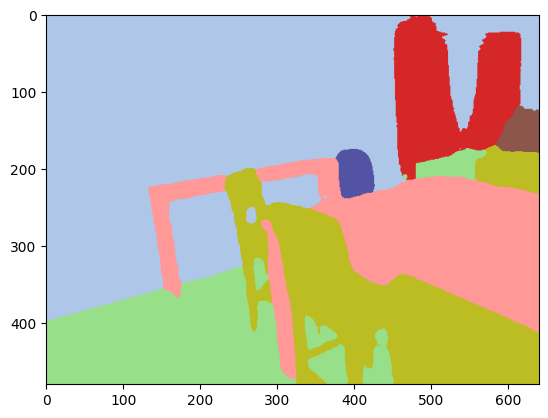

[ 0  1  4  5  6  7  8 19]


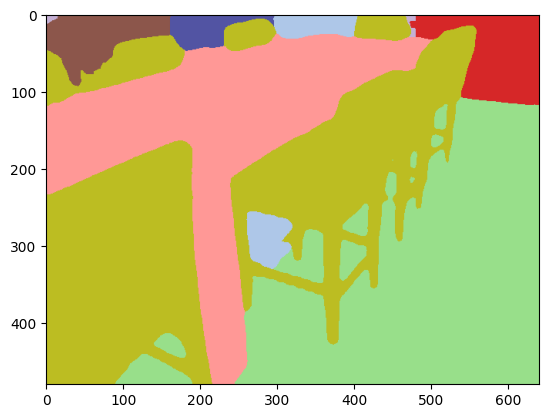

[ 0  1  5  6  7 19]


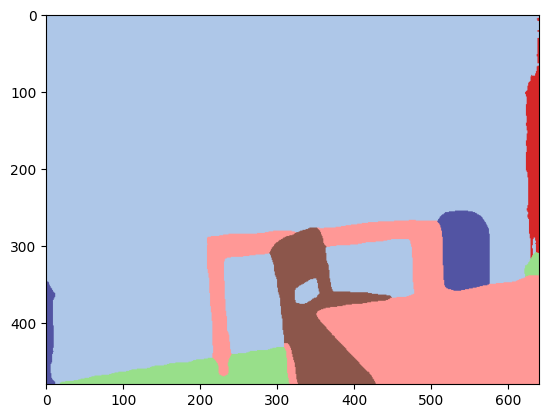

In [11]:
imgs = np.array(['/project/fsun/dvata/scannet-neucon-smallres-m2f/raw/scans/scene0011_00/sens/color/1138.jpg',
        '/project/fsun/dvata/scannet-neucon-smallres-m2f/raw/scans/scene0011_00/sens/color/1604.jpg',
        '/project/fsun/dvata/scannet-neucon-smallres-m2f/raw/scans/scene0011_00/sens/color/1188.jpg'])

masks = np.array(['/home/fsun/data/scannet/scans/scene0011_00/ViT_masks/1138.jpg',
        '/home/fsun/data/scannet/scans/scene0011_00/ViT_masks/1604.jpg',
        '/home/fsun/data/scannet/scans/scene0011_00/ViT_masks/1188.jpg'])

for i, im in enumerate(masks):
#     im = im.split("/")
#     im[1] = 'home'
#     im[-3] = 'color_resized'
#     im.pop(-2)
#     im = "/".join(im)
    im = im.replace("jpg", "png")
    seg_im = Image.open(im)
    seg_im_np = np.array(seg_im) -1
    
    if i == 2:
        seg_im_np[seg_im_np == 4] = 5
    print(np.unique(seg_im_np))

    seg_im_rgb = np.array(CLASS_COLORS)[seg_im_np.astype(int)]

    seg_im_rgb = Image.fromarray(seg_im_rgb.astype(np.uint8))
    plt.imshow(seg_im_rgb)
    plt.show()
    
      